# CNN (Convolutional Neural Network)
**Definition:** A ConvNet is made up of Layers. Every Layer has a simple API: It transforms an input 3D volume to an output 3D volume with some differentiable function that may or may not have parameters.  
**Layers:** Three main types of layers to build ConvNet architectures: 
1. Convolutional Layer (CONV)
2. Pooling Layer (POOL)
3. Fully-Connected Layer (FC)  
<img src="images/CNN.png">

## Why CNN?
**Regular Neural Nets don’t scale well to full images.**  
Let's calculate the number of parameters in the multi-layer perceptron we trained for MNIST dataset.  
Parameters for network:
* 3 layers in the network (2 hidden and 1 output layer)  
* Both hidden layers had 256 nodes and output layer had 10 nodes
* Size of input image 28x28 (= 1x784)  
* Size of weight matrix between input layer and first hidden layer: (784 + 1)x256 = 200960 parameters (1 is from the bias node in input layer)  
* Size of weight matrix between first hidden layer and second hidden layer: (256 + 1)x256 = 65792 parameters (1 is from the bias node in first hidden layer)  
* Size of weight matrix between second hidden layer and output layer: (256 + 1)x10 = 2570 parameters (1 is from the bias node in second hidden layer)  
* Total number of parameters to be learnt by the network: 200960 + 65792 + 2570 = 269322 parameters ~ 270000 parameters!  

And this number is for a very small gray scale image. In real world applications, we deal with big color images (about 200x200x3 is a respectable size but the size can be even bigger). If we were to train the exact same network as above for a 200x200x3 image (here 3 is for the three color channels i.e. Red, Green and Blue aka RGB), then the network needs to learn about 31 million parameters!  
**In other words, the regular multi layer perceptron network size blows up very quickly for larger sized images.**  
This is where CNN comes to the rescue as it reduces the number of parameters very significantly so that I don't have to be reborn to see the result of my network. In particular, unlike a regular Neural Network, the layers of a ConvNet have neurons arranged in 3 dimensions: width, height, depth. (Note that the word depth here refers to the third dimension of an activation volume, not to the depth of a full Neural Network, which can refer to the total number of layers in a network.) For example, in the above case the size of the input layer will be 200x200x3(width, height, depth respectively). As we will soon see, the neurons in a layer will only be connected to a small region of the layer before it, instead of all of the neurons in a fully-connected manner. Moreover, the final output layer would have dimensions 1x1x10, because by the end of the ConvNet architecture we will reduce the full image into a single vector of class scores, arranged along the depth dimension.

## Convolution Layer
[Convolution](https://en.wikipedia.org/wiki/Convolution)  
The CONV layer’s parameters consist of a set of learnable filters. These filters help extract certain features from the signal. Like in electronics, we have high pass filter that filters out lower frequencies from signals and returns higher frequencies present in the signal and vice versa for low pass filter. Similarly filters in image recognition are used to extract edges, corners, boundaries etc. from the image.

(9, 9)


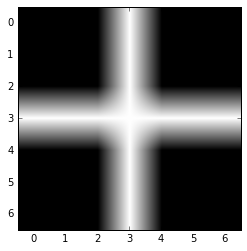

In [74]:
from scipy import misc, signal
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from skimage.filters import threshold_otsu
%matplotlib inline

def convolve_signal(img, filter_function):
    filtered_img = []
    for i in range(img.shape[0]):
        row = img[i,:]
        filtered_img.append(np.convolve(row, filter_function))
    return filtered_img
    
## Filter 1
line_filter = [[0,0,0],
               [1,1,1],
               [0,0,0]]
img = [[0,0,0,1,0,0,0],
       [0,0,0,1,0,0,0],
       [0,0,0,1,0,0,0],
       [1,1,1,1,1,1,1],
       [0,0,0,1,0,0,0],
       [0,0,0,1,0,0,0],
       [0,0,0,1,0,0,0]]
#img = misc.imread('images/Lenna.png', flatten=True)
filtered_img = signal.convolve2d(img, line_filter)
#filtered_img = convolve_signal(img, line_filter)
plt.imshow(img, cmap=cm.gray)

thresh = threshold_otsu(filtered_img)
binary = filtered_img > thresh

print np.array(filtered_img).shape

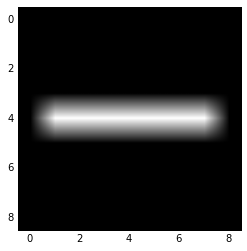

In [75]:
plt.imshow(binary, cmap=cm.gray)

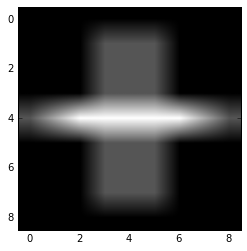

In [76]:
plt.imshow(filtered_img, cmap=cm.gray)

### Hyperparameters for CNN:
* Receptive field: Size of the filter  
* Depth: Number of filters in the CONV layer  
* Stride: Distance by which we move the filter  
* Zero-padding: Additional zeros that are padded to the input  

### Parameter Sharing:
Real-world example. The Krizhevsky et al. architecture that won the ImageNet challenge in 2012 accepted images of size [227x227x3]. On the first Convolutional Layer, it used neurons with receptive field size F=11, stride S=4 and no zero padding P=0. Since (227 - 11)/4 + 1 = 55, and since the Conv layer had a depth of K=96K=96, the Conv layer output volume had size [55x55x96]. Each of the 55*55*96 neurons in this volume was connected to a region of size [11x11x3] in the input volume. Moreover, all 96 neurons in each depth column are connected to the same [11x11x3] region of the input, but of course with different weights. As a fun aside, if you read the actual paper it claims that the input images were 224x224, which is surely incorrect because (224 - 11)/4 + 1 is quite clearly not an integer. This has confused many people in the history of ConvNets and little is known about what happened. My own best guess is that Alex used zero-padding of 3 extra pixels that he does not mention in the paper.

Parameter Sharing.Parameter sharing scheme is used in Convolutional Layers to control the number of parameters. Using the real-world example above, we see that there are 55*55*96 = 290,400 neurons in the first Conv Layer, and each has 11*11*3 = 363 weights and 1 bias. Together, this adds up to 290400 * 364 = 105,705,600 parameters on the first layer of the ConvNet alone. Clearly, this number is very high.

It turns out that we can dramatically reduce the number of parameters by making one reasonable assumption: That if one feature is useful to compute at some spatial position (x,y), then it should also be useful to compute at a different position (x2,y2). In other words, denoting a single 2-dimensional slice of depth as a depth slice (e.g. a volume of size [55x55x96] has 96 depth slices, each of size [55x55]), we are going to constrain the neurons in each depth slice to use the same weights and bias. With this parameter sharing scheme, the first Conv Layer in our example would now have only 96 unique set of weights (one for each depth slice), for a total of 96*11*11*3 = 34,848 unique weights, or 34,944 parameters (+96 biases). Alternatively, all 55*55 neurons in each depth slice will now be using the same parameters. In practice during backpropagation, every neuron in the volume will compute the gradient for its weights, but these gradients will be added up across each depth slice and only update a single set of weights per slice.

### Connectivity
When dealing with high-dimensional inputs such as images, as we saw above it is impractical to connect neurons to all neurons in the previous volume. Instead, we will connect each neuron to only a local region of the input volume. The extent of the connectivity along the depth axis is always equal to the depth of the input volume.  
**The connections are local in space (along width and height), but always full along the entire depth of the input volume.**  

For example, suppose that the input volume has size [32x32x3]. If the receptive field (or the filter size) is 5x5, then each neuron in the Conv Layer will have weights to a [5x5x3] region in the input volume, for a total of 5*5*3 = 75 weights (and +1 bias parameter).  

The **depth** of the CONV layer is a hyperparameter: it corresponds to the number of filters we would like to use, each learning to look for something different in the input. For example, if the first Convolutional Layer takes as input the raw image, then different neurons along the depth dimension may activate in presence of various oriented edged, or blobs of color. We will refer to a set of neurons that are all looking at the same region of the input as a depth column (some people also prefer the term fibre).  
Second, we must specify the **stride** with which we slide the filter. When the stride is 1 then we move the filters one pixel at a time. When the stride is 2 (or uncommonly 3 or more, though this is rare in practice) then the filters jump 2 pixels at a time as we slide them around. This will produce smaller output volumes spatially.  
Sometimes it will be convenient to pad the input volume with zeros around the border. The size of this **zero-padding** is a hyperparameter. The nice feature of zero padding is that it will allow us to control the spatial size of the output volumes (most commonly as we’ll see soon we will use it to exactly preserve the spatial size of the input volume so the input and output width and height are the same).